In [15]:
from __future__ import annotations

import random
from dataclasses import dataclass
from typing import Tuple, Dict, List

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchdiffeq import odeint
import torchcde  # may be unused but kept for completeness

In [16]:
def set_seed(seed: int = 1337) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


@dataclass
class NSConfig:
    grid_size: int = 32  # lower grid size
    viscosity: float = 1e-2
    horizon: float = 0.2
    time_step: float = 1e-3
    samples: int = 150
    batch_size: int = 10
    train_frac: float = 0.6
    val_frac: float = 0.2  # test_frac = 1 - train_frac - val_frac

    olfm_fm_epochs: int = 300
    olfm_finetune_epochs: int = 100
    baseline_epochs: int = 200
    baseline_patience: int = 30


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

set_seed(1337)

## **Data generation**

In [17]:
def generate_initial_vorticity(nx: int, rng: np.random.Generator | None = None) -> np.ndarray:
    """Sample a random vorticity field (Gaussian random field in spectral space)."""
    if rng is None:
        rng = np.random.default_rng()

    x = np.linspace(0.0, 1.0, nx, endpoint=False)
    y = np.linspace(0.0, 1.0, nx, endpoint=False)
    X, Y = np.meshgrid(x, y)

    nk = nx // 2 + 1
    w_hat = np.zeros((nx, nk), dtype=np.complex128)

    k = np.fft.rfftfreq(nx) * nx
    l = np.fft.fftfreq(nx) * nx
    KX, KY = np.meshgrid(k, l)
    K2 = KX ** 2 + KY ** 2
    K2[0, 0] = 1.0

    amp = K2 ** -1.5
    amp[0, 0] = 0.0

    phase = rng.uniform(0, 2 * np.pi, (nx, nk))
    w_hat = amp * np.exp(1j * phase)

    w = np.fft.irfft2(w_hat, s=(nx, nx))
    w = (w - w.mean()) / (w.std() + 1e-8)
    return w


def simulate_ns_2d(w0: np.ndarray, *, horizon: float, dt: float, nu: float) -> np.ndarray:
    """Solve 2D Navier–Stokes (vorticity form) on the periodic unit square."""
    nx = w0.shape[0]
    nk = nx // 2 + 1
    w_hat = np.fft.rfft2(w0)

    kx = np.fft.rfftfreq(nx, 1.0 / nx) * 2 * np.pi
    ky = np.fft.fftfreq(nx, 1.0 / nx) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    K2 = KX ** 2 + KY ** 2

    K2_inv = np.zeros_like(K2)
    mask_nonzero = K2 > 1e-8
    K2_inv[mask_nonzero] = 1.0 / K2[mask_nonzero]

    # 2/3 dealiasing rule
    kmax = nx // 3
    mask = (np.abs(KX) < kmax * 2 * np.pi) & (np.abs(KY) < kmax * 2 * np.pi)

    nsteps = int(horizon / dt)
    for _ in range(nsteps):
        psi_hat = -K2_inv * w_hat
        u_hat = 1j * KY * psi_hat
        v_hat = -1j * KX * psi_hat

        u = np.fft.irfft2(u_hat, s=(nx, nx))
        v = np.fft.irfft2(v_hat, s=(nx, nx))
        w = np.fft.irfft2(w_hat, s=(nx, nx))

        uw_hat = np.fft.rfft2(u * w)
        vw_hat = np.fft.rfft2(v * w)

        conv_hat = -1j * KX * uw_hat - 1j * KY * vw_hat
        diff_hat = -nu * K2 * w_hat

        w_hat = w_hat + dt * (conv_hat + diff_hat)
        w_hat = w_hat * mask

    return np.fft.irfft2(w_hat, s=(nx, nx))


def build_dataset(cfg: NSConfig) -> Tuple[np.ndarray, np.ndarray]:
    """Build dataset of Navier–Stokes initial and final vorticity fields."""
    initials: List[np.ndarray] = []
    finals: List[np.ndarray] = []

    rng = np.random.default_rng(seed=1337)
    for _ in range(cfg.samples):
        w0 = generate_initial_vorticity(cfg.grid_size, rng=rng)
        wT = simulate_ns_2d(w0, horizon=cfg.horizon, dt=cfg.time_step, nu=cfg.viscosity)
        initials.append(w0)
        finals.append(wT)

    return np.asarray(initials), np.asarray(finals)

# **Dataset and splits**

In [18]:
def encode_field(u_phys: np.ndarray) -> np.ndarray:
    """Flatten physical grid [B, Nx, Nx] into [B, Nx*Nx]."""
    u = np.asarray(u_phys)
    if u.ndim == 2:
        u = u[None, ...]
    B, Nx, Ny = u.shape
    return u.reshape(B, -1)


def decode_latent(latent: np.ndarray, nx: int) -> np.ndarray:
    """Reshape flat latent [B, Nx*Nx] back to physical grid [B, Nx, Nx]."""
    z = np.asarray(latent)
    if z.ndim == 1:
        z = z[None, :]
    B = z.shape[0]
    return z.reshape(B, nx, nx)

In [19]:
class NSDataset(Dataset):
    def __init__(self, u0: np.ndarray, uT: np.ndarray):
        assert u0.shape == uT.shape
        flat_u0 = encode_field(u0)
        flat_uT = encode_field(uT)
        self.u0 = torch.from_numpy(flat_u0.astype(np.float32))
        self.uT = torch.from_numpy(flat_uT.astype(np.float32))

    def __len__(self) -> int:
        return self.u0.shape[0]

    def __getitem__(self, idx: int):
        return self.u0[idx], self.uT[idx]


def make_splits(cfg: NSConfig, initials: np.ndarray, finals: np.ndarray):
    N = initials.shape[0]
    indices = np.random.permutation(N)

    n_train = int(cfg.train_frac * N)
    n_val = int(cfg.val_frac * N)
    n_test = N - n_train - n_val

    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]

    train_u0, train_uT = initials[train_idx], finals[train_idx]
    val_u0, val_uT = initials[val_idx], finals[val_idx]
    test_u0, test_uT = initials[test_idx], finals[test_idx]

    train_ds = NSDataset(train_u0, train_uT)
    val_ds = NSDataset(val_u0, val_uT)
    test_ds = NSDataset(test_u0, test_uT)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False)

    return (
        train_u0,
        train_uT,
        val_u0,
        val_uT,
        test_u0,
        test_uT,
        train_loader,
        val_loader,
        test_loader,
    )

## **OLFM**

In [20]:
class TinyMLP(nn.Module):
    def __init__(self, in_dim: int = 3, hidden: int = 48, zero_init: bool = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )
        if zero_init:
            self.net[-1].weight.data.fill_(0.0)
            self.net[-1].bias.data.fill_(0.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class SpectralOperator2D(nn.Module):
    """2D spectral operator used for OLFM."""

    def __init__(self, nx: int, lip_cap: float = 1.5, hidden: int = 128):
        super().__init__()
        self.nx = nx
        self.nk = nx // 2 + 1
        self.lip_cap = lip_cap

        self.A_mlp = TinyMLP(in_dim=3, hidden=hidden, zero_init=True)
        self.B_mlp = TinyMLP(in_dim=3, hidden=hidden, zero_init=True)
        self.sigma = nn.Tanh()

    def forward(self, z_flat: torch.Tensor, t_scalar: torch.Tensor) -> torch.Tensor:
        B = z_flat.shape[0]
        u_phys = z_flat.view(B, self.nx, self.nx)
        w_hat = torch.fft.rfft2(u_phys)

        kx = torch.fft.rfftfreq(self.nx, 1.0 / self.nx, device=z_flat.device)
        ky = torch.fft.fftfreq(self.nx, 1.0 / self.nx, device=z_flat.device)
        KX, KY = torch.meshgrid(kx, ky, indexing="xy")

        KX = KX / (self.nx / 2.0)
        KY = KY / (self.nx / 2.0)

        grid = torch.stack([KX, KY], dim=-1).unsqueeze(0).expand(B, -1, -1, -1)
        t_map = t_scalar.view(B, 1, 1, 1).expand(B, self.nx, self.nk, 1)
        inp = torch.cat([grid, t_map], dim=-1)

        Ar_i = self.A_mlp(inp)
        Br_i = self.B_mlp(inp)

        cap = self.lip_cap
        A = torch.complex(
            torch.tanh(Ar_i[..., 0]) * cap,
            torch.tanh(Ar_i[..., 1]) * cap,
        )
        Bm = torch.complex(
            torch.tanh(Br_i[..., 0]) * cap,
            torch.tanh(Br_i[..., 1]) * cap,
        )

        linear = A * w_hat

        v_phys = self.sigma(u_phys)
        v_hat = torch.fft.rfft2(v_phys)
        nonlinear = Bm * v_hat

        out_hat = linear + nonlinear
        out_phys = torch.fft.irfft2(out_hat, s=(self.nx, self.nx))
        return out_phys.reshape(B, -1)


def lipschitz_penalty(
    model: SpectralOperator2D,
    target_cap: float = 1.5,
    weight: float = 1e-3,
) -> torch.Tensor:
    # Default set to zero for this benchmark
    return torch.tensor(0.0, device=next(model.parameters()).device)


def project_constraints(z: torch.Tensor) -> torch.Tensor:
    # Enforce zero mean vorticity
    return z - z.mean(dim=1, keepdim=True)


def integrate_final_torch(
    model: SpectralOperator2D,
    z0: torch.Tensor,
    steps: int = 100,
) -> torch.Tensor:
    """Integrate OLFM dynamics from z0 to final z using explicit Euler."""
    model.eval()
    with torch.no_grad():
        z = z0.clone()
        dt = 1.0 / steps
        time = 0.0

        for _ in range(steps):
            t_ten = torch.full((z.shape[0],), time, device=z.device)
            dz = model(z, t_ten)
            z = z + dt * dz
            z = project_constraints(z)
            time += dt

    return z


def integrate_trajectory_numpy(
    model: SpectralOperator2D,
    z0: torch.Tensor,
    steps: int = 100,
) -> np.ndarray:
    """Integrate OLFM and return full trajectory as numpy array."""
    model.eval()
    z = z0.clone()
    dt = 1.0 / steps
    traj = [z.detach().cpu().numpy()]
    time = 0.0
    for _ in range(steps):
        t_ten = torch.full((z.shape[0],), time, device=z.device)
        dz = model(z, t_ten)
        z = z + dt * dz
        z = project_constraints(z)
        time += dt
        traj.append(z.detach().cpu().numpy())
    return np.array(traj)


def train_flow_matching(
    model: SpectralOperator2D,
    optimizer: torch.optim.Optimizer,
    z0: torch.Tensor,
    zT: torch.Tensor,
    epochs: int = 200,
    batch_size: int = 4,
) -> List[float]:
    """Pure flow matching training (no validation, no rollout)."""
    model.train()
    n = z0.shape[0]
    losses: List[float] = []

    for epoch in range(epochs):
        perm = torch.randperm(n, device=z0.device)
        running_loss = 0.0
        n_batches = 0

        for start in range(0, n, batch_size):
            idx = perm[start:start + batch_size]
            z0_b, zT_b = z0[idx], zT[idx]

            t = torch.rand(len(idx), device=z0.device)
            zt = (1.0 - t.view(-1, 1)) * z0_b + t.view(-1, 1) * zT_b
            target_v = zT_b - z0_b

            pred_v = model(zt, t)
            loss = torch.mean((pred_v - target_v) ** 2) + lipschitz_penalty(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

        avg_loss = running_loss / max(1, n_batches)
        losses.append(avg_loss)

        if (epoch + 1) % 20 == 0:
            print(f"[OLFM] FM Epoch {epoch + 1:03d}/{epochs}, loss={avg_loss:.4e}")

    return losses


def finetune_olfm_with_rollout(
    model: SpectralOperator2D,
    optimizer: torch.optim.Optimizer,
    z0_train: torch.Tensor,
    zT_train: torch.Tensor,
    z0_val: torch.Tensor,
    zT_val: torch.Tensor,
    epochs: int = 100,
    batch_size: int = 10,
    steps: int = 20,
    patience: int = 20,
) -> Dict[str, List[float]]:
    """Fine tune OLFM with rollout loss and early stopping on validation MSE."""
    model.train()
    n = z0_train.shape[0]
    dt = 1.0 / steps
    mse_loss = nn.MSELoss()

    history: Dict[str, List[float]] = {"train_fm": [], "train_rollout": [], "val_mse": []}

    best_val = float("inf")
    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        permutation = torch.randperm(n, device=z0_train.device)
        running_fm = 0.0
        running_roll = 0.0
        n_batches = 0

        for start in range(0, n, batch_size):
            idx = permutation[start:start + batch_size]
            z0_b = z0_train[idx]
            zT_b = zT_train[idx]

            # Flow matching term
            t_batch = torch.rand(z0_b.shape[0], device=z0_b.device)
            zt_batch = (1.0 - t_batch.view(-1, 1)) * z0_b + t_batch.view(-1, 1) * zT_b
            target_velocity = zT_b - z0_b
            loss_fm = torch.mean((model(zt_batch, t_batch) - target_velocity) ** 2)

            # Rollout term
            z_pred = z0_b.clone()
            time = 0.0
            for _ in range(steps):
                t_tensor = torch.full(
                    (z_pred.shape[0],),
                    time,
                    dtype=torch.float32,
                    device=z0_b.device,
                )
                z_pred = z_pred + dt * model(z_pred, t_tensor)
                z_pred = project_constraints(z_pred)
                time += dt

            loss_rollout = torch.mean((z_pred - zT_b) ** 2)
            loss = loss_fm + 0.1 * loss_rollout + lipschitz_penalty(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_fm += loss_fm.item()
            running_roll += loss_rollout.item()
            n_batches += 1

        avg_fm = running_fm / max(1, n_batches)
        avg_roll = running_roll / max(1, n_batches)
        history["train_fm"].append(avg_fm)
        history["train_rollout"].append(avg_roll)

        # Validation MSE via full integration
        model.eval()
        with torch.no_grad():
            z_pred_val = integrate_final_torch(model, z0_val, steps=50)
            val_mse = mse_loss(z_pred_val, zT_val).item()
        history["val_mse"].append(val_mse)

        if (epoch == 1) or (epoch % 10 == 0):
            print(
                f"[OLFM] FT Epoch {epoch:03d}/{epochs}, "
                f"FM={avg_fm:.4e}, Roll={avg_roll:.4e}, val MSE={val_mse:.4e}"
            )

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"[OLFM] Early stopping at epoch {epoch} with best val MSE {best_val:.4e}")
            break

        model.train()

    model.load_state_dict(best_state)
    return history


def train_olfm(
    cfg: NSConfig,
    train_u0: np.ndarray,
    train_uT: np.ndarray,
    val_u0: np.ndarray,
    val_uT: np.ndarray,
) -> Tuple[SpectralOperator2D, Dict[str, List[float]]]:
    nx = cfg.grid_size
    z0_train = torch.tensor(encode_field(train_u0), dtype=torch.float32, device=DEVICE)
    zT_train = torch.tensor(encode_field(train_uT), dtype=torch.float32, device=DEVICE)
    z0_val = torch.tensor(encode_field(val_u0), dtype=torch.float32, device=DEVICE)
    zT_val = torch.tensor(encode_field(val_uT), dtype=torch.float32, device=DEVICE)

    model = SpectralOperator2D(nx=nx, hidden=128).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training OLFM (flow matching stage)...")
    fm_losses = train_flow_matching(
        model,
        opt,
        z0_train,
        zT_train,
        epochs=cfg.olfm_fm_epochs,
        batch_size=cfg.batch_size,
    )

    print("Fine tuning OLFM with rollout and validation early stopping...")
    history_ft = finetune_olfm_with_rollout(
        model,
        opt,
        z0_train,
        zT_train,
        z0_val,
        zT_val,
        epochs=cfg.olfm_finetune_epochs,
        batch_size=cfg.batch_size,
        steps=20,
        patience=20,
    )

    history: Dict[str, List[float]] = {
        "fm_loss": fm_losses,
        "train_fm": history_ft["train_fm"],
        "train_rollout": history_ft["train_rollout"],
        "val_mse": history_ft["val_mse"],
    }
    return model, history

## **Latent ODE**

In [21]:
class LatentODEFunc(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
        )

    def forward(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.net(z)


class LatentODEModel(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int = 256, hidden_dim: int = 256):
        super().__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.func = LatentODEFunc(latent_dim, hidden_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)

    def forward(self, x0_flat: torch.Tensor) -> torch.Tensor:
        z0 = self.encoder(x0_flat)
        t = torch.tensor([0.0, 1.0], device=x0_flat.device)
        zT = odeint(self.func, z0, t, method="rk4")[1]
        xT_pred = self.decoder(zT)
        return xT_pred

## **Neural CDE**

In [22]:
class CDEFunc(nn.Module):
    """Vector field f(z, u) for the CDE: dz/dt = f(z(t), u(t))."""

    def __init__(self, hidden_dim: int, path_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.path_dim = path_dim
        self.net = nn.Sequential(
            nn.Linear(hidden_dim + path_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
        )

    def forward(self, z: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        inp = torch.cat([z, u], dim=-1)
        dz = self.net(inp)
        return dz


class NeuralCDEModel(nn.Module):
    """
    Neural CDE baseline with explicit Euler integration.
    Control path: X(t) = t * g(w0) with learned embedding g(w0).
    """

    def __init__(
        self,
        input_dim: int,
        path_dim: int = 64,
        hidden_dim: int = 128,
        output_dim: int | None = None,
        steps: int = 10,
    ):
        super().__init__()
        if output_dim is None:
            output_dim = input_dim

        self.input_dim = input_dim
        self.path_dim = path_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.steps = steps

        self.path_encoder = nn.Linear(input_dim, path_dim)
        self.hidden_init = nn.Linear(input_dim, hidden_dim)
        self.func = CDEFunc(hidden_dim=hidden_dim, path_dim=path_dim)
        self.readout = nn.Linear(hidden_dim, output_dim)

    def forward(self, x0_flat: torch.Tensor) -> torch.Tensor:
        B = x0_flat.size(0)

        g = self.path_encoder(x0_flat)
        z = self.hidden_init(x0_flat)

        K = self.steps
        dt = 1.0 / float(K)
        t = 0.0

        for _ in range(K):
            t = t + dt
            u_t = t * g
            dz = self.func(z, u_t)
            z = z + dt * dz

        y = self.readout(z)
        return y

## **FNO**

In [23]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes1: int, modes2: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.weight = nn.Parameter(
            torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat) * 0.01
        )

    def compl_mul2d(self, input: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
        # (batch, in_c, m1, m2) x (in_c, out_c, m1, m2) -> (batch, out_c, m1, m2)
        return torch.einsum("bixy,ioxy->boxy", input, weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batchsize, in_c, nx, ny = x.shape
        x_ft = torch.fft.rfft2(x, norm="ortho")

        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            nx,
            ny // 2 + 1,
            dtype=torch.cfloat,
            device=x.device,
        )

        mx = min(self.modes1, nx)
        my = min(self.modes2, ny // 2 + 1)
        out_ft[:, :, :mx, :my] = self.compl_mul2d(
            x_ft[:, :, :mx, :my],
            self.weight[:, :, :mx, :my],
        )

        x_out = torch.fft.irfft2(out_ft, s=(nx, ny), norm="ortho")
        return x_out


class FNO2d(nn.Module):
    def __init__(
        self,
        modes1: int,
        modes2: int,
        width: int,
        in_channels: int = 1,
        out_channels: int = 1,
    ):
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.fc0 = nn.Linear(in_channels + 2, width)

        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def get_grid(self, batchsize: int, size_x: int, size_y: int, device: torch.device) -> torch.Tensor:
        x = torch.linspace(0, 1, size_x, device=device)
        y = torch.linspace(0, 1, size_y, device=device)
        gridx = x.view(1, 1, size_x, 1).repeat(batchsize, 1, 1, size_y)
        gridy = y.view(1, 1, 1, size_y).repeat(batchsize, 1, size_x, 1)
        return torch.cat((gridx, gridy), dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batchsize, _, size_x, size_y = x.shape
        device = x.device

        grid = self.get_grid(batchsize, size_x, size_y, device)
        x = torch.cat([x, grid], dim=1)

        x = x.permute(0, 2, 3, 1)  # [B, Nx, Ny, C]
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)  # [B, width, Nx, Ny]

        x1 = self.conv0(x)
        x = F.gelu(x1 + self.w0(x))

        x1 = self.conv1(x)
        x = F.gelu(x1 + self.w1(x))

        x1 = self.conv2(x)
        x = F.gelu(x1 + self.w2(x))

        x1 = self.conv3(x)
        x = F.gelu(x1 + self.w3(x))

        x = x.permute(0, 2, 3, 1)  # [B, Nx, Ny, width]
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # [B, Nx, Ny, out_channels]
        x = x.permute(0, 3, 1, 2)  # [B, out_channels, Nx, Ny]
        return x


class FNORegression(nn.Module):
    """Wrapper to make FNO behave as flat-to-flat regression."""

    def __init__(self, nx: int, modes1: int, modes2: int, width: int = 32):
        super().__init__()
        self.nx = nx
        self.model = FNO2d(
            modes1=modes1,
            modes2=modes2,
            width=width,
            in_channels=1,
            out_channels=1,
        )

    def forward(self, x0_flat: torch.Tensor) -> torch.Tensor:
        B = x0_flat.shape[0]
        u0 = x0_flat.view(B, 1, self.nx, self.nx)
        uT_pred = self.model(u0)
        return uT_pred.view(B, -1)

## **Training**

In [24]:
def train_regression_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    cfg: NSConfig,
    model_name: str,
    lr: float = 1e-3,
) -> Dict[str, List[float]]:
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    train_losses: List[float] = []
    val_losses: List[float] = []

    best_val = float("inf")
    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    patience_counter = 0

    for epoch in range(1, cfg.baseline_epochs + 1):
        model.train()
        running_train = 0.0
        n_batches = 0

        for x0, xT in train_loader:
            x0 = x0.to(DEVICE)
            xT = xT.to(DEVICE)

            optimizer.zero_grad()
            pred = model(x0)
            loss = mse_loss(pred, xT)
            loss.backward()
            optimizer.step()

            running_train += loss.item()
            n_batches += 1

        train_loss = running_train / max(1, n_batches)
        train_losses.append(train_loss)

        model.eval()
        running_val = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for x0, xT in val_loader:
                x0 = x0.to(DEVICE)
                xT = xT.to(DEVICE)
                pred = model(x0)
                loss = mse_loss(pred, xT)
                running_val += loss.item()
                n_val_batches += 1

        val_loss = running_val / max(1, n_val_batches)
        val_losses.append(val_loss)

        if (epoch == 1) or (epoch % 10 == 0):
            print(
                f"[{model_name}] Epoch {epoch:03d}/{cfg.baseline_epochs}, "
                f"train={train_loss:.4e}, val={val_loss:.4e}"
            )

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= cfg.baseline_patience:
            print(f"[{model_name}] Early stopping at epoch {epoch} with best val {best_val:.4e}")
            break

    model.load_state_dict(best_state)
    model.to(DEVICE)
    return {"train_loss": train_losses, "val_loss": val_losses}


def evaluate_flat_model(
    model: nn.Module,
    data_loader: DataLoader,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    model.eval()
    mse_list: List[np.ndarray] = []
    preds: List[np.ndarray] = []
    trues: List[np.ndarray] = []

    with torch.no_grad():
        for x0, xT in data_loader:
            x0 = x0.to(DEVICE)
            xT = xT.to(DEVICE)
            pred = model(x0)
            mse_batch = ((pred - xT) ** 2).mean(dim=1).cpu().numpy()
            mse_list.append(mse_batch)
            preds.append(pred.cpu().numpy())
            trues.append(xT.cpu().numpy())

    mse_all = np.concatenate(mse_list, axis=0)
    preds_all = np.concatenate(preds, axis=0)
    trues_all = np.concatenate(trues, axis=0)
    return mse_all, preds_all, trues_all


def evaluate_olfm_model(
    model: SpectralOperator2D,
    u0_test: np.ndarray,
    uT_test: np.ndarray,
    steps: int = 100,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    z0_test = torch.tensor(encode_field(u0_test), dtype=torch.float32, device=DEVICE)
    zT_test = torch.tensor(encode_field(uT_test), dtype=torch.float32, device=DEVICE)

    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        z_pred = integrate_final_torch(model, z0_test, steps=steps)
        mse_all = ((z_pred - zT_test) ** 2).mean(dim=1).cpu().numpy()
        preds_all = z_pred.cpu().numpy()
        trues_all = zT_test.cpu().numpy()

    return mse_all, preds_all, trues_all

## **Diagnostics and plotting**

In [25]:
def get_spectrum(w: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    nx = w.shape[0]
    w_hat = np.fft.rfft2(w)
    k = np.fft.rfftfreq(nx) * nx
    l = np.fft.fftfreq(nx) * nx
    KX, KY = np.meshgrid(k, l)
    K = np.sqrt(KX ** 2 + KY ** 2)

    k_bins = np.arange(0, nx // 2 + 1)
    E_k = np.zeros_like(k_bins, dtype=float)
    for i in range(len(k_bins) - 1):
        mask = (K >= k_bins[i]) & (K < k_bins[i + 1])
        E_k[i] = np.sum(np.abs(w_hat[mask]) ** 2)

    return k_bins, E_k


def plot_training_curves(histories: Dict[str, Dict[str, List[float]]]) -> None:
    plt.figure(figsize=(10, 6))
    for name, hist in histories.items():
        if "train_loss" in hist and "val_loss" in hist:
            plt.plot(hist["train_loss"], label=f"{name} train")
            plt.plot(hist["val_loss"], label=f"{name} val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Training and validation curves (baselines)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    if "OLFM" in histories:
        hist = histories["OLFM"]
        plt.figure(figsize=(10, 4))
        plt.plot(hist["val_mse"], label="OLFM val MSE")
        plt.xlabel("Fine tune epoch")
        plt.ylabel("MSE")
        plt.title("OLFM validation MSE during fine tuning")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


def plot_mse_summary(test_mses: Dict[str, np.ndarray]) -> None:
    names = list(test_mses.keys())
    means = [test_mses[k].mean() for k in names]
    stds = [test_mses[k].std() for k in names]

    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, names)
    plt.ylabel("Test MSE")
    plt.title("Test MSE summary (mean ± std)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.boxplot([test_mses[k] for k in names], labels=names, showmeans=True)
    plt.ylabel("Test MSE")
    plt.title("Test MSE distribution")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_field_comparisons(
    cfg: NSConfig,
    test_u0: np.ndarray,
    test_uT: np.ndarray,
    preds_flat: Dict[str, np.ndarray],
    sample_idx: int = 0,
) -> None:
    nx = cfg.grid_size
    w0 = test_u0[sample_idx]
    true_wT = test_uT[sample_idx]

    vmin, vmax = true_wT.min(), true_wT.max()

    for name, pred_flat in preds_flat.items():
        pred_wT = decode_latent(pred_flat[sample_idx], nx)[0]
        error = np.abs(true_wT - pred_wT)

        plt.figure(figsize=(14, 3.5))
        plt.subplot(141)
        plt.title("Initial w0")
        plt.imshow(w0, cmap="RdBu_r")
        plt.colorbar()

        plt.subplot(142)
        plt.title("True wT")
        plt.imshow(true_wT, cmap="RdBu_r", vmin=vmin, vmax=vmax)
        plt.colorbar()

        plt.subplot(143)
        plt.title(f"{name} pred wT")
        plt.imshow(pred_wT, cmap="RdBu_r", vmin=vmin, vmax=vmax)
        plt.colorbar()

        plt.subplot(144)
        plt.title(f"{name} |error|")
        plt.imshow(error, cmap="inferno")
        plt.colorbar()

        plt.suptitle(f"Model {name} – sample {sample_idx}")
        plt.tight_layout()
        plt.show()


def plot_spectrum_comparison(
    cfg: NSConfig,
    test_uT: np.ndarray,
    preds_flat: Dict[str, np.ndarray],
    sample_idx: int = 0,
) -> None:
    nx = cfg.grid_size
    true_wT = test_uT[sample_idx]
    k_true, E_true = get_spectrum(true_wT)

    plt.figure(figsize=(8, 4))
    plt.loglog(k_true[1:], E_true[1:], label="True", linewidth=2)

    for name, pred_flat in preds_flat.items():
        pred_wT = decode_latent(pred_flat[sample_idx], nx)[0]
        k_pred, E_pred = get_spectrum(pred_wT)
        plt.loglog(k_pred[1:], E_pred[1:], linestyle="--", label=name)

    plt.xlabel("Wavenumber k")
    plt.ylabel("Energy E(k)")
    plt.title("Vorticity energy spectra comparison")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## **Benchmarking**

Device: mps
Grid size: 32x32
Generating 2D Navier–Stokes dataset...
Data shape: (150, 32, 32)
Training OLFM (flow matching stage)...
[OLFM] FM Epoch 020/300, loss=6.3397e-03
[OLFM] FM Epoch 040/300, loss=6.4450e-03
[OLFM] FM Epoch 060/300, loss=6.4255e-03
[OLFM] FM Epoch 080/300, loss=5.7115e-03
[OLFM] FM Epoch 100/300, loss=3.8982e-03
[OLFM] FM Epoch 120/300, loss=3.8430e-03
[OLFM] FM Epoch 140/300, loss=4.0125e-03
[OLFM] FM Epoch 160/300, loss=3.5019e-03
[OLFM] FM Epoch 180/300, loss=3.5460e-03
[OLFM] FM Epoch 200/300, loss=3.4313e-03
[OLFM] FM Epoch 220/300, loss=3.6919e-03
[OLFM] FM Epoch 240/300, loss=3.2224e-03
[OLFM] FM Epoch 260/300, loss=3.4143e-03
[OLFM] FM Epoch 280/300, loss=3.1645e-03
[OLFM] FM Epoch 300/300, loss=2.9212e-03
Fine tuning OLFM with rollout and validation early stopping...
[OLFM] FT Epoch 001/100, FM=3.1848e-03, Roll=1.9934e-03, val MSE=2.0622e-03
[OLFM] FT Epoch 010/100, FM=2.9987e-03, Roll=2.1708e-03, val MSE=2.1513e-03
[OLFM] FT Epoch 020/100, FM=2.8586e-0

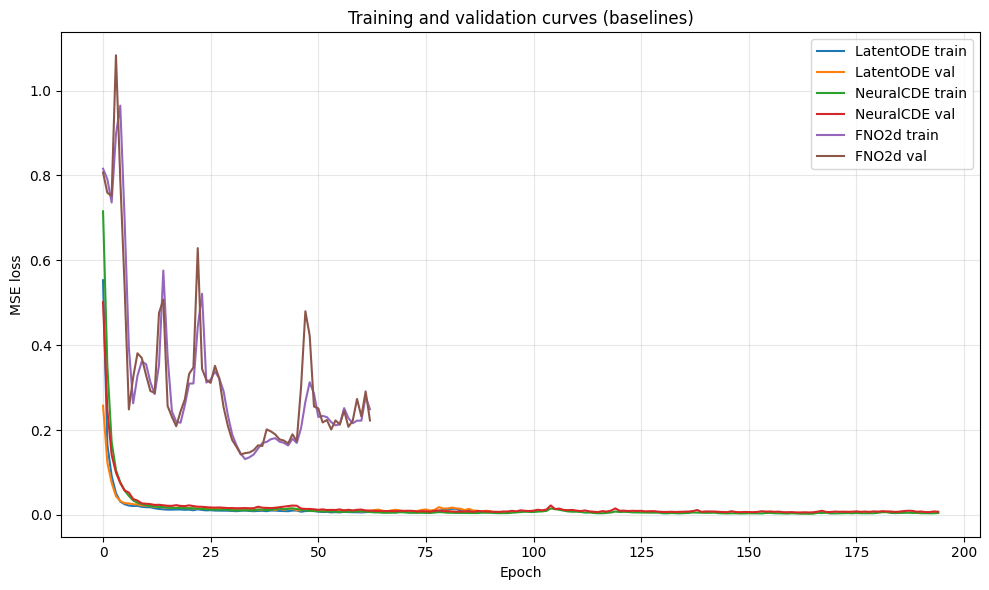

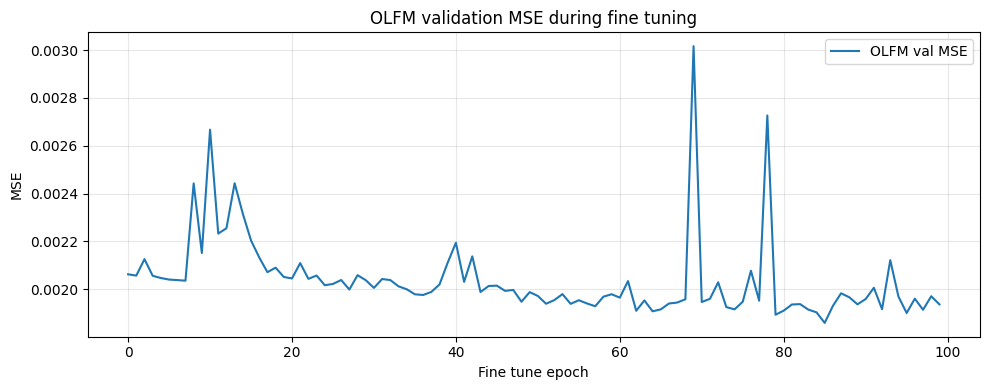

Plotting test MSE summary across models...


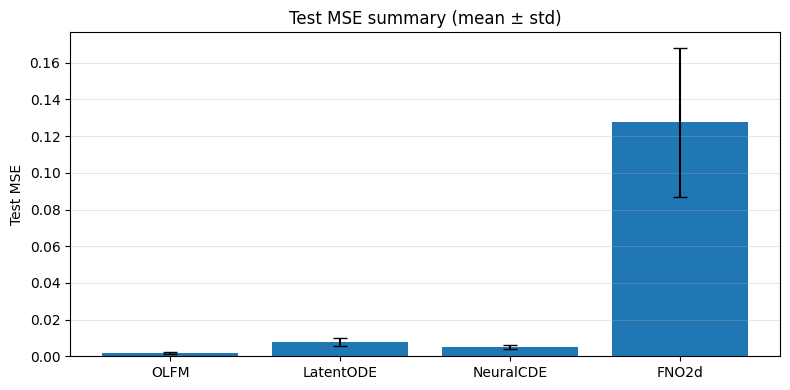

/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_3052/4215862152.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([test_mses[k] for k in names], labels=names, showmeans=True)


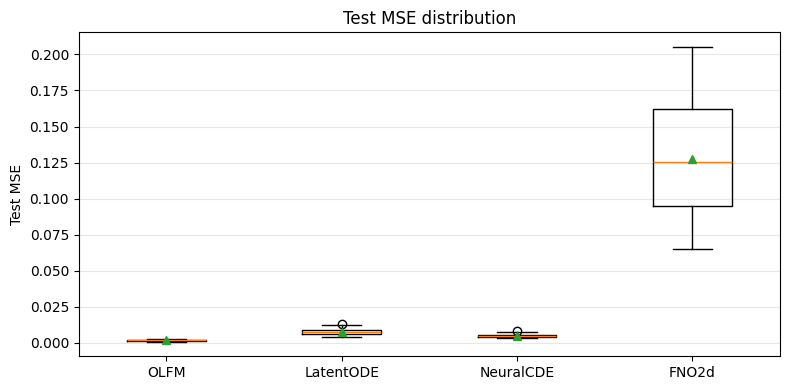

Plotting field comparisons for sample 0...


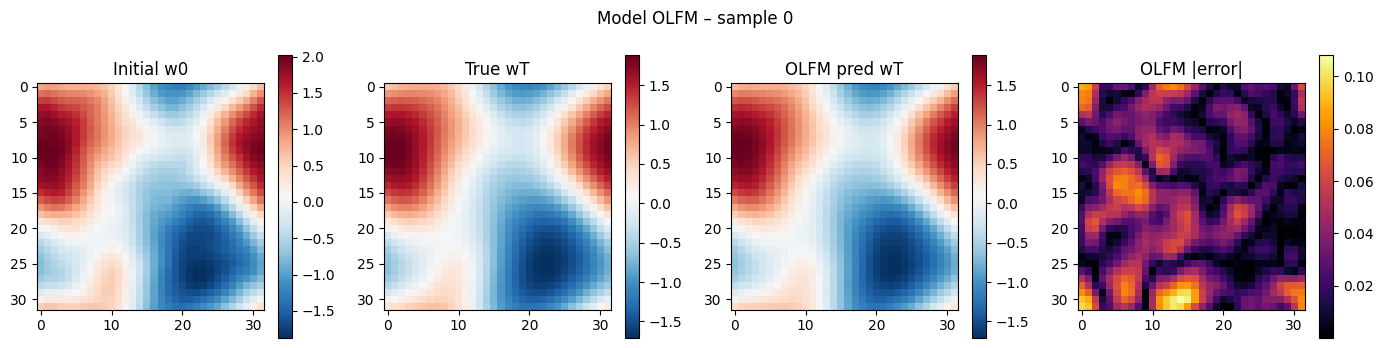

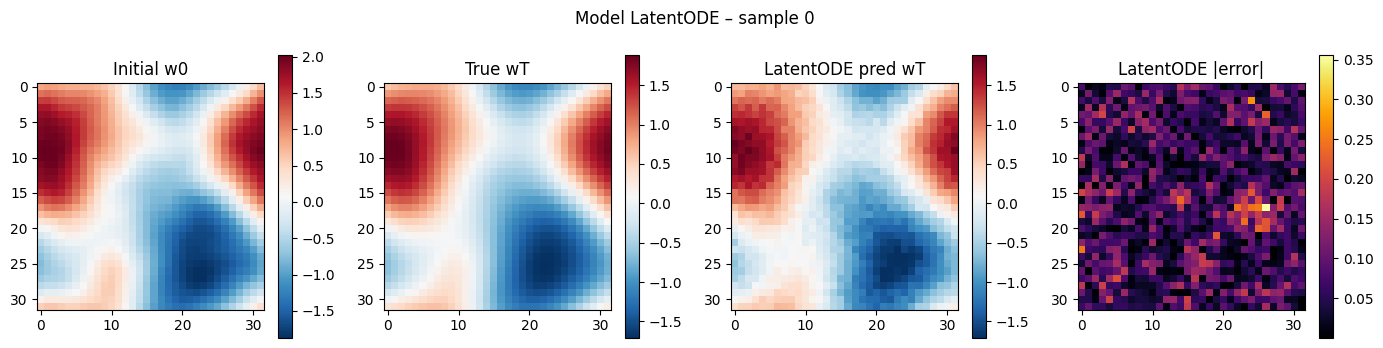

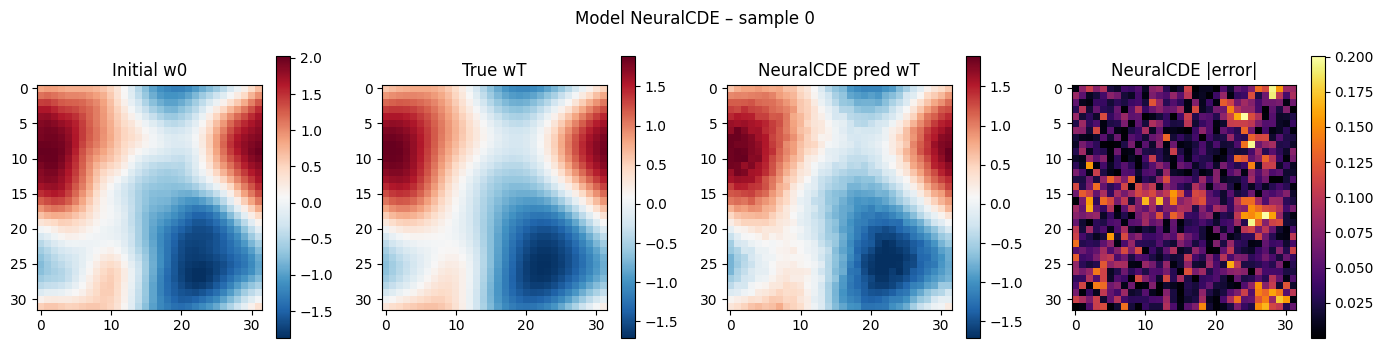

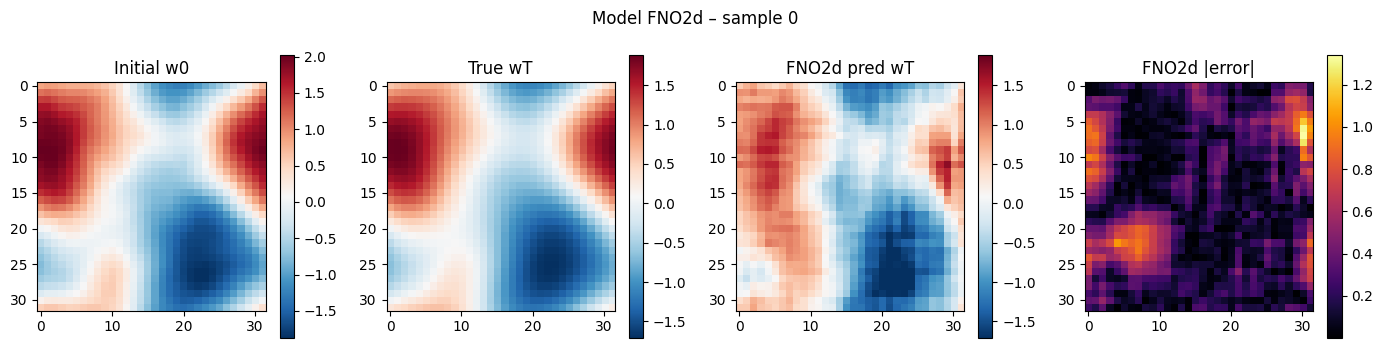

Plotting spectral comparison for sample 0...


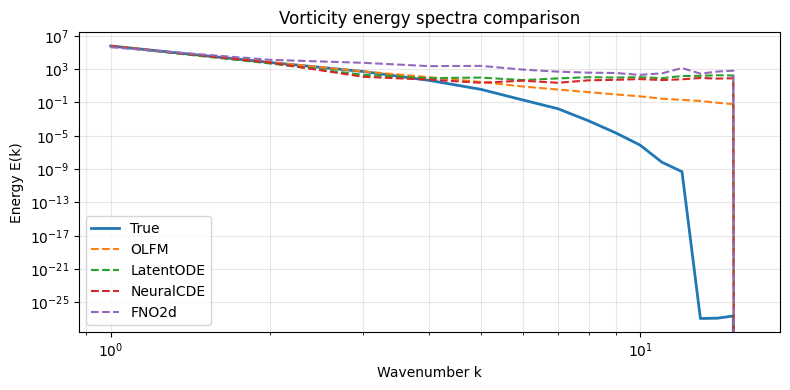

In [ ]:
def main():
    cfg = NSConfig()
    print(f"Device: {DEVICE}")
    print(f"Grid size: {cfg.grid_size}x{cfg.grid_size}")
    print("Generating 2D Navier–Stokes dataset...")
    initials, finals = build_dataset(cfg)
    print("Data shape:", initials.shape)

    (
        train_u0,
        train_uT,
        val_u0,
        val_uT,
        test_u0,
        test_uT,
        train_loader,
        val_loader,
        test_loader,
    ) = make_splits(cfg, initials, finals)

    input_dim = cfg.grid_size * cfg.grid_size

    # ----------------------------- OLFM -----------------------------------
    olfm_model, olfm_hist = train_olfm(cfg, train_u0, train_uT, val_u0, val_uT)

    # --------------------------- Baselines --------------------------------
    baseline_histories: Dict[str, Dict[str, List[float]]] = {}

    print("\nTraining Latent ODE baseline...")
    latent_ode_model = LatentODEModel(input_dim=input_dim, latent_dim=256, hidden_dim=256)
    hist_latent_ode = train_regression_model(
        latent_ode_model,
        train_loader,
        val_loader,
        cfg,
        model_name="LatentODE",
        lr=1e-3,
    )

    print("\nTraining Neural CDE baseline...")
    neural_cde_model = NeuralCDEModel(input_dim=input_dim, path_dim=64, hidden_dim=128, output_dim=input_dim)
    hist_neural_cde = train_regression_model(
        neural_cde_model,
        train_loader,
        val_loader,
        cfg,
        model_name="NeuralCDE",
        lr=1e-3,
    )

    print("\nTraining FNO baseline...")
    modes1 = cfg.grid_size // 2
    modes2 = cfg.grid_size // 2
    fno_regression_model = FNORegression(cfg.grid_size, modes1=modes1, modes2=modes2, width=32)
    hist_fno = train_regression_model(
        fno_regression_model,
        train_loader,
        val_loader,
        cfg,
        model_name="FNO2d",
        lr=1e-3,
    )

    baseline_histories["LatentODE"] = hist_latent_ode
    baseline_histories["NeuralCDE"] = hist_neural_cde
    baseline_histories["FNO2d"] = hist_fno
    baseline_histories["OLFM"] = olfm_hist

    # --------------------------- Evaluation -------------------------------
    print("\nEvaluating all models on test set...")
    olfm_mse, olfm_pred_flat, olfm_true_flat = evaluate_olfm_model(
        olfm_model,
        test_u0,
        test_uT,
        steps=100,
    )
    latent_mse, latent_pred_flat, latent_true_flat = evaluate_flat_model(
        latent_ode_model,
        test_loader,
    )
    cde_mse, cde_pred_flat, cde_true_flat = evaluate_flat_model(
        neural_cde_model,
        test_loader,
    )
    fno_mse, fno_pred_flat, fno_true_flat = evaluate_flat_model(
        fno_regression_model,
        test_loader,
    )

    test_mses: Dict[str, np.ndarray] = {
        "OLFM": olfm_mse,
        "LatentODE": latent_mse,
        "NeuralCDE": cde_mse,
        "FNO2d": fno_mse,
    }
    preds_flat: Dict[str, np.ndarray] = {
        "OLFM": olfm_pred_flat,
        "LatentODE": latent_pred_flat,
        "NeuralCDE": cde_pred_flat,
        "FNO2d": fno_pred_flat,
    }

    print("\nTest MSE (mean over test set):")
    for name, mse_vals in test_mses.items():
        print(f" {name:10s}: {mse_vals.mean():.4e} ± {mse_vals.std():.4e}")

    # ----------------------------- Plots ----------------------------------
    print("\nPlotting training and validation curves...")
    plot_training_curves(baseline_histories)

    print("Plotting test MSE summary across models...")
    plot_mse_summary(test_mses)

    sample_idx = 0
    print(f"Plotting field comparisons for sample {sample_idx}...")
    plot_field_comparisons(cfg, test_u0, test_uT, preds_flat, sample_idx=sample_idx)

    print(f"Plotting spectral comparison for sample {sample_idx}...")
    plot_spectrum_comparison(cfg, test_uT, preds_flat, sample_idx=sample_idx)


if __name__ == "__main__":
    main()